In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster
from IPython.display import display, Markdown
import pprint

In [52]:
data = pd.read_csv('dataset.csv')

In [53]:
cleaned_data = data.dropna()
cleaned_data = cleaned_data.drop_duplicates()

In [54]:
# Convert all numeric-looking columns to float if possible
for column in cleaned_data.columns:
    if column != 'defect':
        try:
            cleaned_data[column] = cleaned_data[column].astype(float)
        except:
            pass  # skip non-convertible columns

In [55]:
# Remove non-numeric columns except the label
numeric_columns = cleaned_data.select_dtypes(include=['float64', 'int64']).columns
numeric_features = [col for col in numeric_columns if col != 'defect']

In [56]:
# Optionally remove columns with very low variance (near-constant)
low_variance_features = [col for col in numeric_features if cleaned_data[col].std() < 1e-5]
if low_variance_features:
    print(f"Dropping near-constant features: {low_variance_features}")
    cleaned_data = cleaned_data.drop(columns=low_variance_features)
    numeric_features = [f for f in numeric_features if f not in low_variance_features]

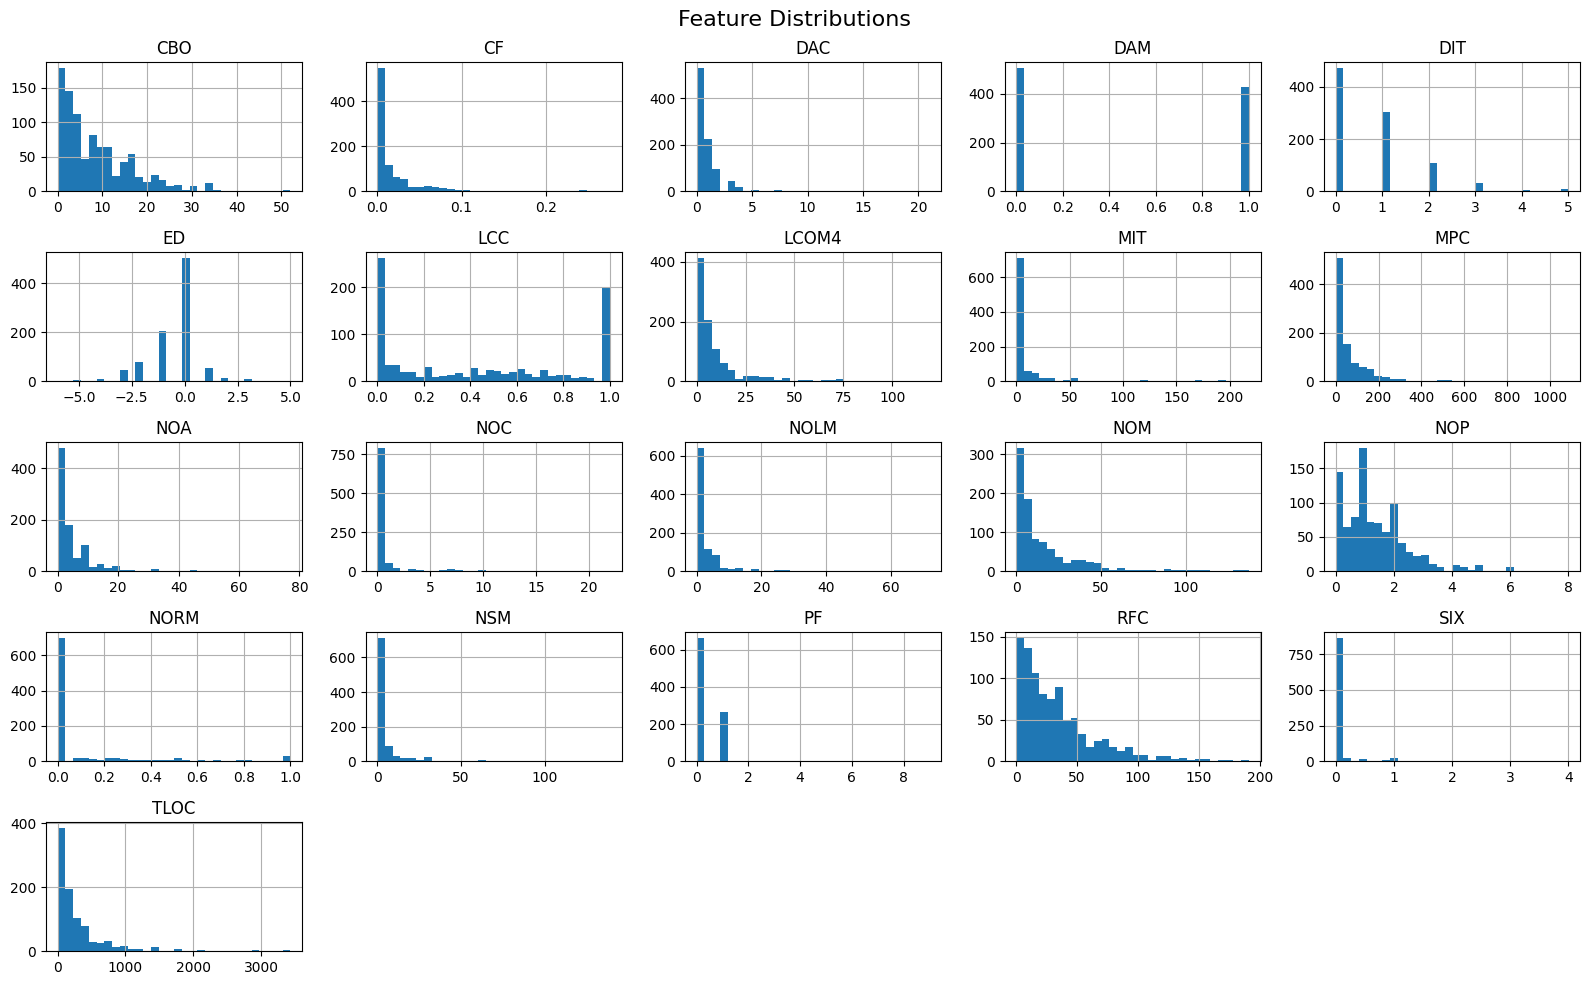

In [57]:
# Step 3: Visualize feature distributions
cleaned_data[numeric_features].hist(figsize=(16, 10), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

In [58]:
# Step 4: Normalize Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cleaned_data[numeric_features])
scaled_data = pd.DataFrame(scaled_features, columns=numeric_features)
scaled_data['defect'] = cleaned_data['defect'].values

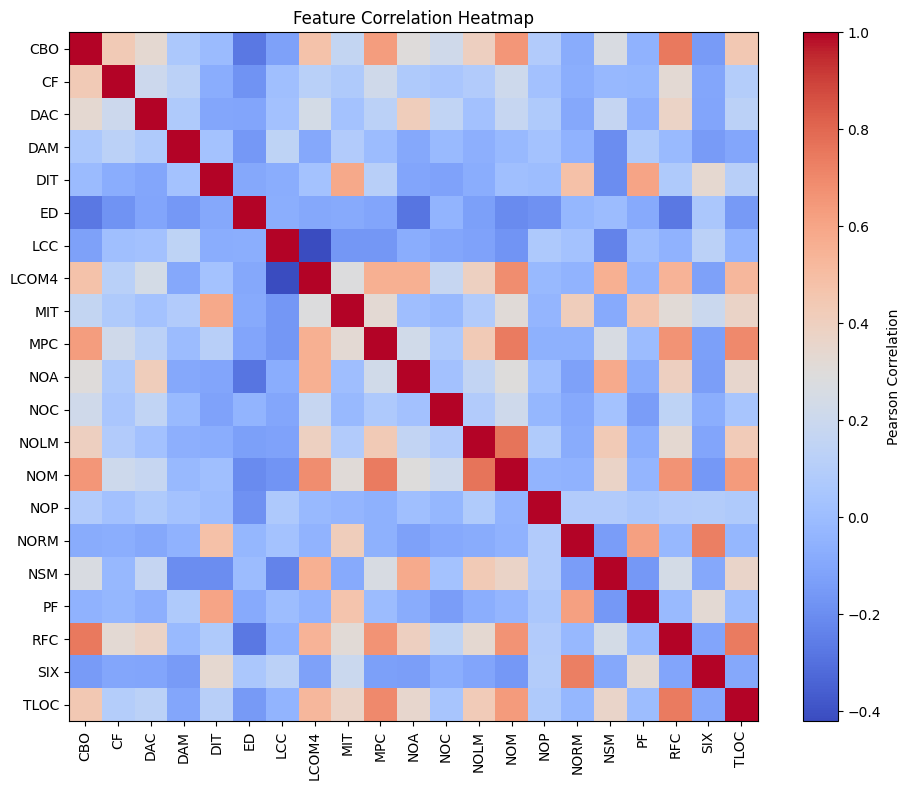

In [59]:
# Step 5: Correlation Matrix & Heatmap
correlation_matrix = scaled_data[numeric_features].corr()
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, interpolation='nearest', cmap='coolwarm')
plt.xticks(ticks=np.arange(len(numeric_features)), labels=numeric_features, rotation=90)
plt.yticks(ticks=np.arange(len(numeric_features)), labels=numeric_features)
plt.colorbar(label="Pearson Correlation")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [60]:
# Step 6: Remove highly correlated features using clustering
linkage_matrix = linkage(correlation_matrix, method='average')
cluster_labels = fcluster(linkage_matrix, t=0.7, criterion='distance')
cluster_dict = {}
for feature, label in zip(numeric_features, cluster_labels):
    cluster_dict.setdefault(label, []).append(feature)
redundant_features = []
for cluster in cluster_dict.values():
    if len(cluster) > 1:
        redundant_features.extend(cluster[1:])  # keep only the first
pruned_features = [f for f in numeric_features if f not in redundant_features]
pruned_data = scaled_data[pruned_features + ['defect']]

In [62]:
# Cluster table
cluster_table = []
for label, features in cluster_dict.items():
    cluster_table.append({
        'Cluster': label,
        'Features': ', '.join(features)
    })
cluster_df = pd.DataFrame(cluster_table).sort_values('Cluster')
display(cluster_df)

# Redundant features
redundant_df = pd.DataFrame({'Redundant Feature': redundant_features})
display(redundant_df)

# Pruned features
pruned_df = pd.DataFrame({'Kept Feature': pruned_features})
display(pruned_df)

# Summary
summary_df = pd.DataFrame({
    'Features Kept': [len(pruned_features)],
    'Features Removed': [len(redundant_features)]
})
display(summary_df)

,Cluster,Features
10,1,NOA
15,2,NSM
0,3,"CBO, RFC"
9,4,"MPC, NOM, TLOC"
7,5,LCOM4
12,6,NOLM
1,7,CF
2,8,DAC
11,9,NOC
14,10,"NORM, SIX"


,Redundant Feature
0,RFC
1,PF
2,NOM
3,TLOC
4,SIX


,Kept Feature
0,CBO
1,CF
2,DAC
3,DAM
4,DIT
5,ED
6,LCC
7,LCOM4
8,MIT
9,MPC


,Features Kept,Features Removed
0,16,5


In [45]:
# Step 7: Logistic Regression & 5-fold CV on full set
X = pruned_data[pruned_features]
y = pruned_data['defect']
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
cv_scores = cross_val_score(logreg, X, y, cv=5)
baseline_accuracy = np.mean(cv_scores)
print(f"Baseline 5-Fold Accuracy: {baseline_accuracy:.4f}")

Baseline 5-Fold Accuracy: 0.7971


In [46]:
# Step 8: Leave-One-Feature-Out Analysis
loo_results = []
for feature in pruned_features:
    X_subset = X.drop(columns=[feature])
    score = cross_val_score(logreg, X_subset, y, cv=5).mean()
    accuracy_drop = baseline_accuracy - score
    loo_results.append({
        'Dropped Feature': feature,
        'Accuracy w/o Feature': score,
        'Accuracy Drop': accuracy_drop
    })
loo_df = pd.DataFrame(loo_results).sort_values(by='Accuracy Drop', ascending=False)
display(Markdown("### Leave-One-Feature-Out Results"))
display(loo_df)

### Leave-One-Feature-Out Results

,Dropped Feature,Accuracy w/o Feature,Accuracy Drop
0,CBO,0.746530,0.050532
8,MIT,0.778782,0.018280
12,NOLM,0.780927,0.016135
5,ED,0.788494,0.008568
2,DAC,0.790622,0.006440
9,MPC,0.791680,0.005382
1,CF,0.791691,0.005371
14,NORM,0.792761,0.004301
10,NOA,0.793830,0.003232
13,NOP,0.794911,0.002151


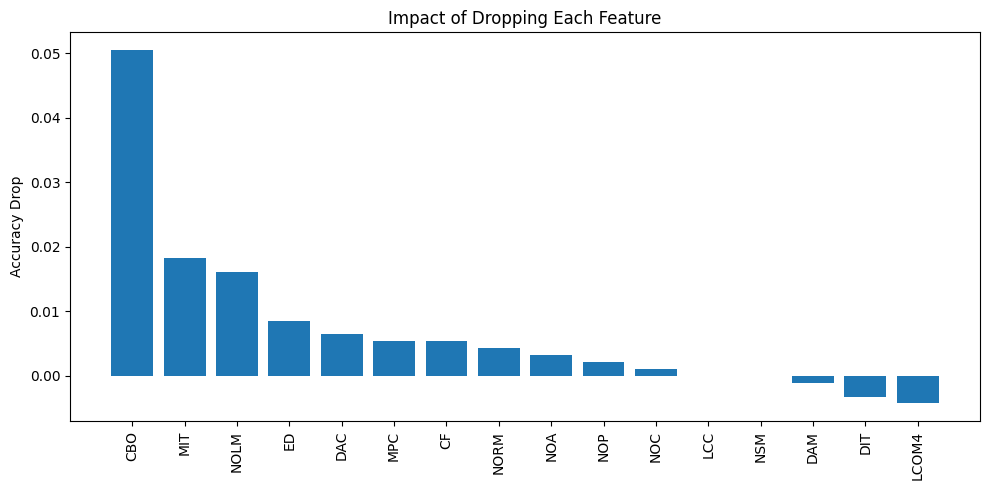

In [47]:
# Step 9: Plot Accuracy Drop
plt.figure(figsize=(10, 5))
plt.bar(loo_df['Dropped Feature'], loo_df['Accuracy Drop'])
plt.xticks(rotation=90)
plt.ylabel("Accuracy Drop")
plt.title("Impact of Dropping Each Feature")
plt.tight_layout()
plt.show()

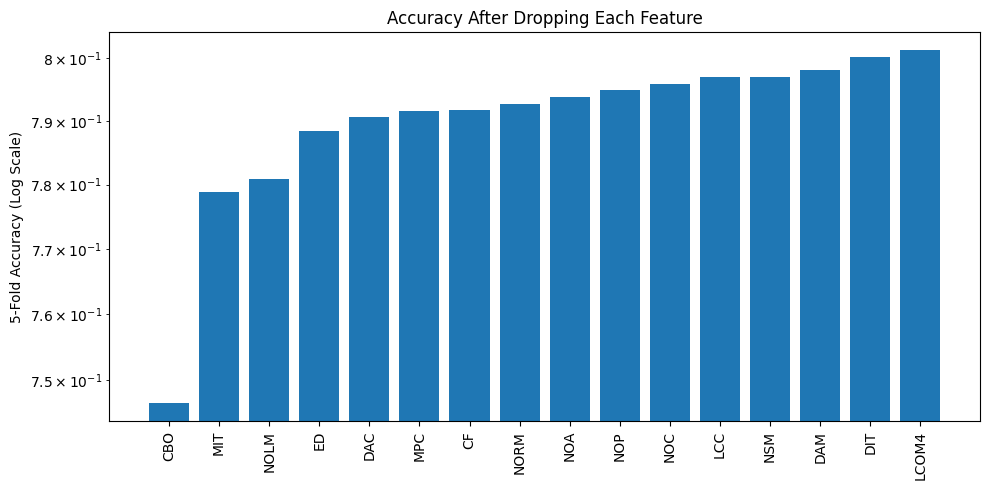

In [49]:
# Step 10: Plot Accuracy Without Feature (with Log Scale)
plt.figure(figsize=(10, 5))
plt.bar(loo_df['Dropped Feature'], loo_df['Accuracy w/o Feature'])
plt.xticks(rotation=90)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.ylabel("5-Fold Accuracy (Log Scale)")
plt.title("Accuracy After Dropping Each Feature")
plt.tight_layout()
plt.show()